# Import libraries

In [39]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers
from keras.models import load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import Automate as au
# import PIL
from PIL import Image
import glob
import cv2
from sklearn.metrics import confusion_matrix
# from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input
# import math
from keras.applications import VGG19

import keras.backend as K


# Load Data 

In [2]:
mainDIR = os.listdir('chest_xray')

In [3]:
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

In [4]:
# train 
os.listdir(train_folder)
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

In [5]:
#test
os.listdir(test_folder)
test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

In [6]:
# Get all the data in the directory test and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), batch_size= 624)

# Get all the data in the directory train and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(128, 128), batch_size=5216)

# Get all the data in the directory Val and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder,
        target_size =(128,128), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
# check shape of images and labels
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(5216, 128, 128, 3)
(5216, 2)
(624, 128, 128, 3)
(624, 2)
(16, 128, 128, 3)
(16, 2)


In [8]:
# flatten the arrays
train_img_unrow = train_images.reshape(train_images.shape[0], -1)
test_img_unrow = test_images.reshape(test_images.shape[0], -1)
val_img_unrow = val_images.reshape(val_images.shape[0], -1)
train_labels_final = np.reshape(train_labels[:,0], (5216,1))
test_labels_final = np.reshape(test_labels[:,0], (624,1))
val_labels_final = np.reshape(val_labels[:,0], (16,1))
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))
print(np.shape(val_img_unrow))
print(np.shape(train_labels_final))
print(np.shape(test_labels_final))
print(np.shape(val_labels_final))

(5216, 49152)
(624, 49152)
(16, 49152)
(5216, 1)
(624, 1)
(16, 1)


In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Graphs and EDA

In [10]:
# Directory path
val_data_dir = val_folder + '/NORMAL/'
val_data_dir_sick = val_folder + '/PNEUMONIA/'

In [11]:
# see the number of images in each folder
trainnorm_Counter = au.image_counter(train_n)
trainsick_Counter = au.image_counter(train_p)
valnorm_Counter = au.image_counter(val_data_dir)
valsick_Counter = au.image_counter(val_data_dir_sick)
testnorm_Counter = au.image_counter(test_n)
testsick_Counter = au.image_counter(test_p)

print(f"""Num of train normal images {trainnorm_Counter}
        Num of train sick images {trainsick_Counter}
        Num of val normal images {valnorm_Counter}
        Num of val sick images {valsick_Counter}
        Num of test normal images {testnorm_Counter}
        Num of test sick images {testsick_Counter}""")

Num of train normal images 1341
        Num of train sick images 3875
        Num of val normal images 8
        Num of val sick images 8
        Num of test normal images 234
        Num of test sick images 390


In [12]:
# put images into a df 1 = pneumonia 0 = normal
traindf = au.images_to_df(train_n, train_p)
testdf = au.images_to_df(test_n, test_p)
traindf.head()
testdf.head()

,image,label
0,IM-0063-0001.jpeg,0
1,NORMAL2-IM-0290-0001.jpeg,0
2,person143_bacteria_688.jpeg,1
3,NORMAL2-IM-0259-0001.jpeg,0
4,IM-0003-0001.jpeg,0


In [13]:
len(traindf)

5216

Text(0, 0.5, 'Count')

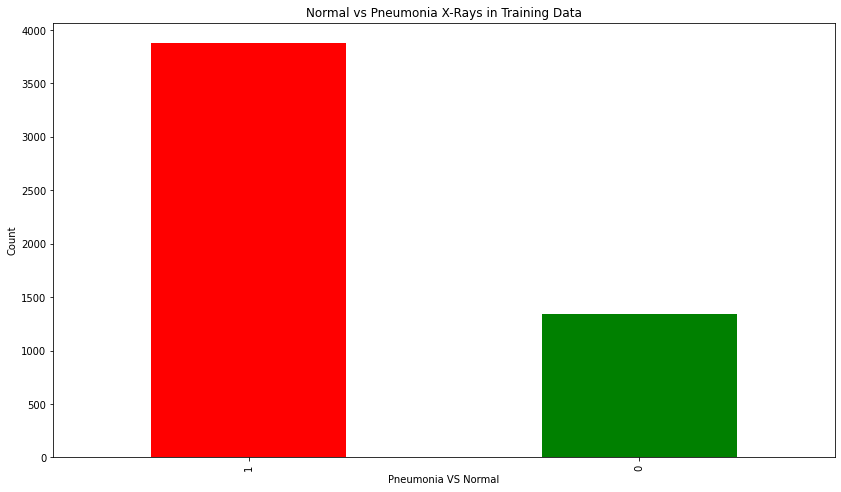

In [14]:
ax = traindf['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Normal vs Pneumonia X-Rays in Training Data",
                                         color = ('red', 'green'))
ax.set_xlabel("Pneumonia VS Normal")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

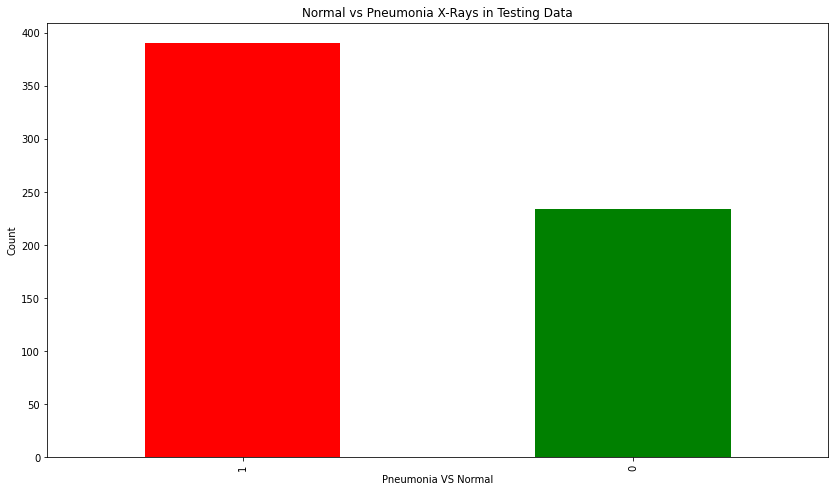

In [15]:
ax2 = testdf['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Normal vs Pneumonia X-Rays in Testing Data",
                                         color = ('red', 'green'))
ax2.set_xlabel("Pneumonia VS Normal")
ax2.set_ylabel("Count")

In [16]:
# get width and height of every image
testwh_data = au.height_width(test_n)
testP_wh_data = au.height_width(test_p)
val_wh_data = au.height_width(val_data_dir)
valP_wh_data = au.height_width(val_data_dir_sick)
train_wh_data = au.height_width(train_n)
trainP_wh_data = au.height_width(train_p)

In [17]:
# concat to one dataframe
frames = [testwh_data, testP_wh_data, val_wh_data, valP_wh_data, train_wh_data, trainP_wh_data]
wh_data = pd.concat(frames)
wh_data.rename(columns = {0:'Width', 1:'Height'}, inplace = True)

In [18]:
wh_data.describe()

,Width,Height
count,5856.000000,5856.000000
mean,1327.880806,970.689037
std,363.500922,383.392117
min,384.000000,127.000000
25%,1056.000000,688.000000
50%,1281.000000,888.000000
75%,1560.000000,1187.000000
max,2916.000000,2713.000000


In [19]:
wh_data['Width'].mean()

1327.880806010929

/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:989: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


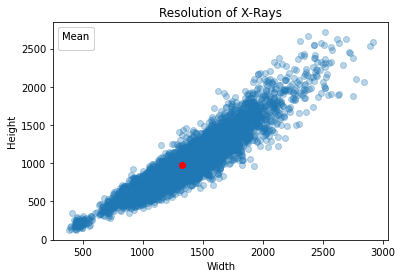

In [20]:
# plot width and height of images
fig= plt.figure()
ax = fig.add_subplot(111)
whole = ax.scatter(wh_data['Width'], wh_data['Height'], alpha = .3)
mean = ax.scatter(wh_data['Width'].mean(), wh_data['Height'].mean(), c = 'red')
ax.set_title('Resolution of X-Rays')
ax.set_xlabel('Width')
ax.set_ylabel('Height')
legend1 = ax.legend(*mean.legend_elements(prop = 'colors'),
                    loc="upper left", title="Mean")
ax.add_artist(legend1)
plt.show()

Pneumonia


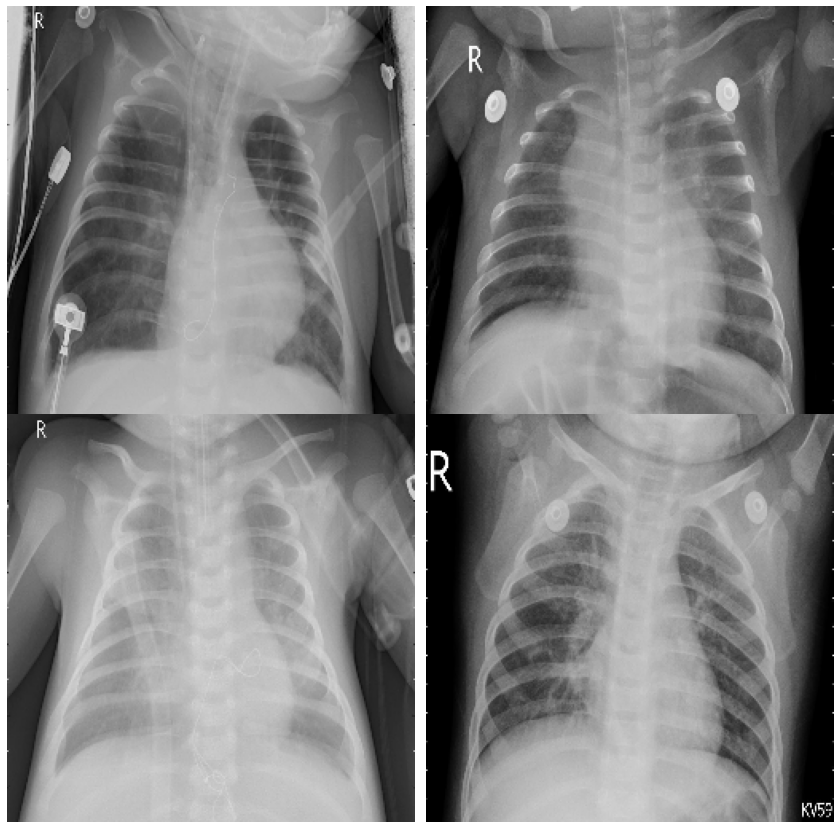

In [21]:
print("Pneumonia")
multipleImages = glob.glob('chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:4]:
    im = cv2.imread(l)
    im = cv2.resize(im, (256, 256)) 
    plt.subplot(2, 2, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Normal


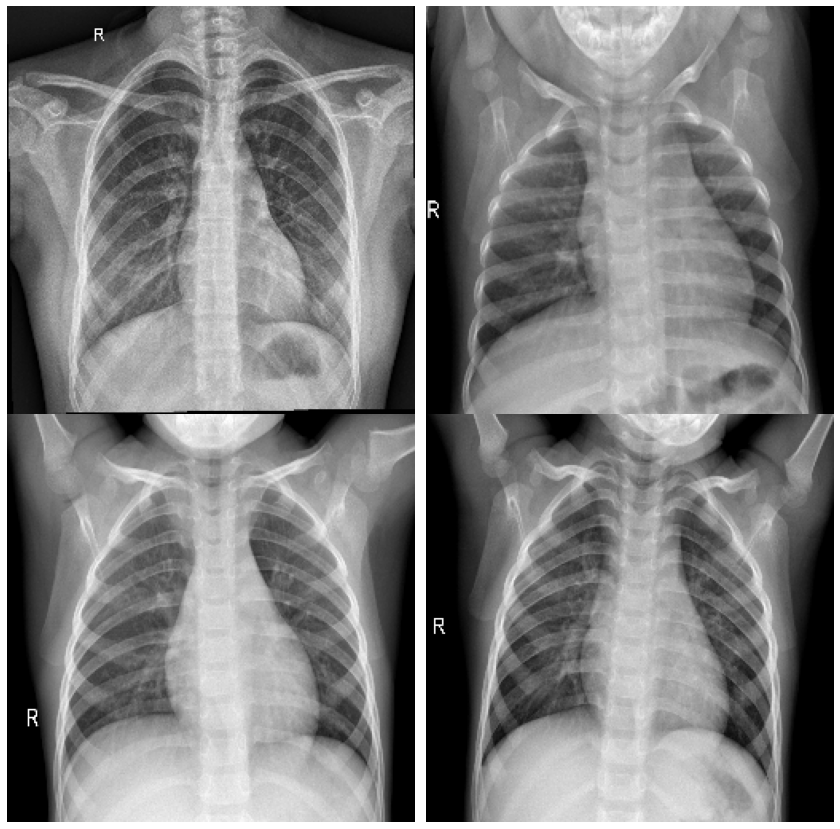

In [22]:
print("Normal")
multipleImages = glob.glob('chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:4]:
    im = cv2.imread(l)
    im = cv2.resize(im, (256, 256)) 
    plt.subplot(2, 2, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1


# CNN

## Basic Model

In [18]:
train_imagestens  = np.array([np.reshape(i, (128, 128,3)) for i in train_images])
val_imagestens  = np.array([np.reshape(i, (128, 128,3)) for i in val_images])
test_imagestens  = np.array([np.reshape(i, (128, 128,3)) for i in test_images])

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(28, activation ='relu'))

model.add(layers.Dense(2, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

In [22]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, min_delta=1)
mcb = ModelCheckpoint('cnn_model1', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [23]:
histor2 = model.fit(train_imagestens,
                    train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_imagestens, val_labels),
                    callbacks=[es, mcb])

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 82s 16ms/step - loss: 0.3926 - accuracy: 0.8267 - val_loss: 0.6573 - val_accuracy: 0.7500
Epoch 2/50


/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5216/5216 [==============================] - 85s 16ms/step - loss: 0.1482 - accuracy: 0.9428 - val_loss: 0.7273 - val_accuracy: 0.7500
Epoch 3/50
5216/5216 [==============================] - 86s 16ms/step - loss: 0.1141 - accuracy: 0.9585 - val_loss: 0.9130 - val_accuracy: 0.7500
Epoch 4/50
5216/5216 [==============================] - 84s 16ms/step - loss: 0.0992 - accuracy: 0.9642 - val_loss: 0.2425 - val_accuracy: 0.9062
Epoch 5/50
5216/5216 [==============================] - 83s 16ms/step - loss: 0.0831 - accuracy: 0.9731 - val_loss: 0.5758 - val_accuracy: 0.8125
Epoch 6/50
5216/5216 [==============================] - 82s 16ms/step - loss: 0.0648 - accuracy: 0.9783 - val_loss: 0.0623 - val_accuracy: 1.0000
Epoch 7/50
5216/5216 [==============================] - 81s 16ms/step - loss: 0.0582 - accuracy: 0.9807 - val_loss: 0.3899 - val_accuracy: 0.7812
Epoch 8/50
5216/5216 [==============================] - 80s 15ms/step - loss: 0.0528 - accuracy: 0.9808 - val_loss: 0.1150 - val_accura

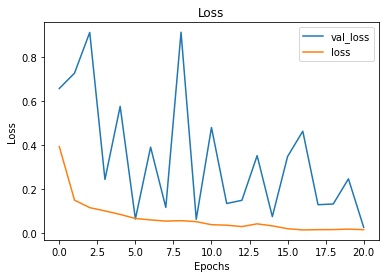

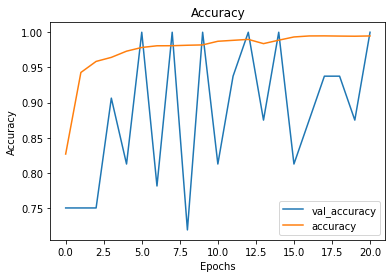

In [24]:
au.visualize_training_results(histor2)

In [25]:
 # load model
modelload = load_model('cnn_model1')
# summarize model.
modelload.summary()

# evaluate the model
score = modelload.evaluate(test_imagestens, test_labels)
print("%s: %.2f%%" % (modelload.metrics_names[1], score[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

### Confusion Matrix

In [26]:
predict = modelload.predict(test_imagestens)
roundpredict = predict.round()

In [27]:
cm = confusion_matrix(test_labels.argmax(axis =1),roundpredict.argmax(axis =1))
classes = ['Normal', 'Pneumonia']

Confusion Matrix, without normalization
[[101 133]
 [  1 389]]


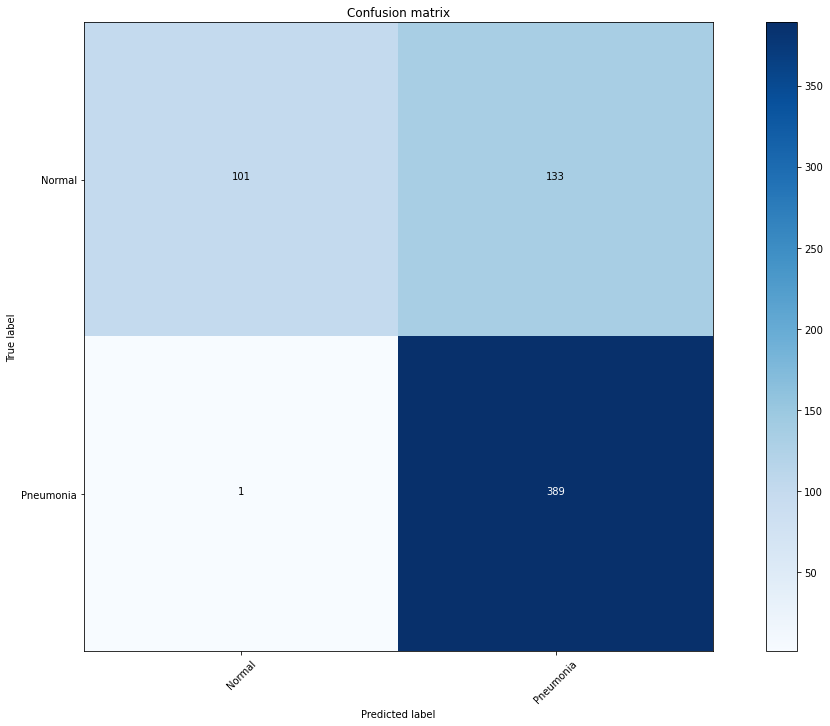

In [28]:
plt.figure(figsize=(15,10))
au.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Data Augmentation 

In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

aug_train_generator = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (128, 128),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

test_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), batch_size= 624, class_mode = 'binary')

val_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder,
        target_size =(128,128), batch_size=64, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Augmentation Model

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(28, activation ='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
mcaug = ModelCheckpoint('cnn_model_aug', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [33]:
history_2 = model.fit_generator(aug_train_generator, 
                                steps_per_epoch= 81.5, #num of train samples/batch
                                epochs=50, 
                                validation_data=val_generator2, 
                                validation_steps= 1.25,
                                callbacks=[es, mcaug])

Epoch 1/50
82/81 [==============================] - 142s 2s/step - loss: 0.5900 - accuracy: 0.7352 - val_loss: 0.8141 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to cnn_model_aug
Epoch 2/50
82/81 [==============================] - 147s 2s/step - loss: 0.4623 - accuracy: 0.7690 - val_loss: 0.4882 - val_accuracy: 0.8125

Epoch 00002: val_accuracy improved from 0.50000 to 0.81250, saving model to cnn_model_aug
Epoch 3/50
82/81 [==============================] - 145s 2s/step - loss: 0.3393 - accuracy: 0.8434 - val_loss: 0.4814 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.81250
Epoch 4/50
82/81 [==============================] - 143s 2s/step - loss: 0.2845 - accuracy: 0.8775 - val_loss: 0.4056 - val_accuracy: 0.8125

Epoch 00004: val_accuracy did not improve from 0.81250
Epoch 5/50
82/81 [==============================] - 141s 2s/step - loss: 0.2660 - accuracy: 0.8834 - val_loss: 0.5173 - val_accuracy: 0.8125

Epo

In [11]:
test_imagesaug, test_labelsaug = next(test_generator2)

In [34]:
 # load model
modelloadaug = load_model('cnn_model_aug')
# summarize model.
modelloadaug.summary()

# evaluate the model
score = modelloadaug.evaluate(test_imagesaug, test_labelsaug)
print("%s: %.2f%%" % (modelloadaug.metrics_names[1], score[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)      

### Confusion Matrix

In [53]:
predictaug = modelloadaug.predict_generator(test_generator2)
roundpredictaug = predictaug.round()

In [54]:
cm2 = confusion_matrix(test_labelsaug,roundpredictaug)

Confusion Matrix, without normalization
[[115 119]
 [159 231]]


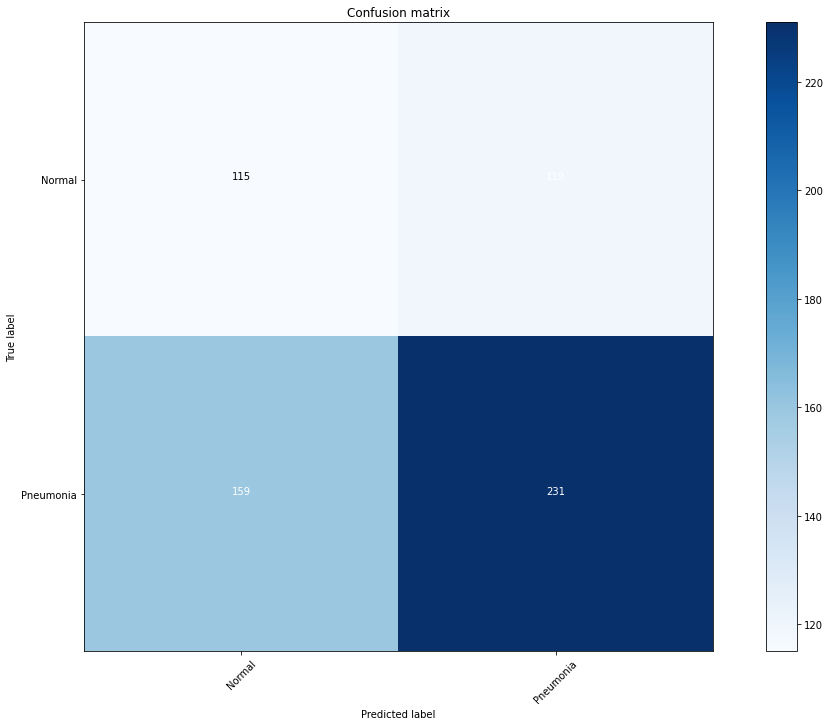

In [55]:
plt.figure(figsize=(15,10))
au.plot_confusion_matrix(cm2, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Transfer learning

In [40]:
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [41]:
modeltl = models.Sequential()
modeltl.add(cnn_base)
modeltl.add(layers.Flatten())
modeltl.add(layers.Dense(64, activation='relu'))
modeltl.add(layers.Dropout(.1))
modeltl.add(layers.Dense(28))

modeltl.add(layers.Dense(1, activation='sigmoid'))

In [42]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in modeltl.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(modeltl.trainable_weights))

vgg19 True
flatten_3 True
dense_7 True
dropout_3 True
dense_8 True
dense_9 True
38


In [43]:
cnn_base.trainable = False

In [44]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in modeltl.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(modeltl.trainable_weights))

vgg19 False
flatten_3 True
dense_7 True
dropout_3 True
dense_8 True
dense_9 True
6


In [45]:
modeltl.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [47]:
mc = ModelCheckpoint('cnn_model_tran', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [48]:
historytl = modeltl.fit_generator(aug_train_generator, 
                                steps_per_epoch= 81.5, #num of train samples/batch
                                epochs=50, 
                                validation_data=val_generator2, 
                                validation_steps= 1.25, #num of val samples/batch
                                callbacks=[es, mc])

Epoch 1/50
82/81 [==============================] - 773s 9s/step - loss: 0.3744 - acc: 0.8384 - val_loss: 0.5117 - val_acc: 0.8125

Epoch 00001: val_acc improved from -inf to 0.81250, saving model to cnn_model_tran
Epoch 2/50


/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


82/81 [==============================] - 766s 9s/step - loss: 0.2102 - acc: 0.9137 - val_loss: 0.4533 - val_acc: 0.8125

Epoch 00002: val_acc did not improve from 0.81250
Epoch 3/50
82/81 [==============================] - 802s 10s/step - loss: 0.1851 - acc: 0.9277 - val_loss: 0.5145 - val_acc: 0.7500

Epoch 00003: val_acc did not improve from 0.81250
Epoch 4/50
82/81 [==============================] - 855s 10s/step - loss: 0.1704 - acc: 0.9321 - val_loss: 0.5405 - val_acc: 0.8125

Epoch 00004: val_acc did not improve from 0.81250
Epoch 5/50
82/81 [==============================] - 833s 10s/step - loss: 0.1622 - acc: 0.9362 - val_loss: 0.5583 - val_acc: 0.8125

Epoch 00005: val_acc did not improve from 0.81250
Epoch 6/50
82/81 [==============================] - 637s 8s/step - loss: 0.1626 - acc: 0.9342 - val_loss: 0.8922 - val_acc: 0.7500

Epoch 00006: val_acc did not improve from 0.81250
Epoch 7/50
82/81 [==============================] - 633s 8s/step - loss: 0.1686 - acc: 0.9350 - va


Epoch 00046: val_acc did not improve from 0.87500
Epoch 47/50
82/81 [==============================] - 608s 7s/step - loss: 0.1297 - acc: 0.9509 - val_loss: 0.4016 - val_acc: 0.8750

Epoch 00047: val_acc did not improve from 0.87500
Epoch 48/50
82/81 [==============================] - 606s 7s/step - loss: 0.1181 - acc: 0.9536 - val_loss: 0.9432 - val_acc: 0.7500

Epoch 00048: val_acc did not improve from 0.87500
Epoch 49/50
82/81 [==============================] - 603s 7s/step - loss: 0.1201 - acc: 0.9542 - val_loss: 0.5495 - val_acc: 0.8750

Epoch 00049: val_acc did not improve from 0.87500
Epoch 50/50
82/81 [==============================] - 604s 7s/step - loss: 0.1230 - acc: 0.9559 - val_loss: 0.3141 - val_acc: 0.8750

Epoch 00050: val_acc did not improve from 0.87500


In [49]:
 # load model
modelloadtl = load_model('cnn_model_tran')
# summarize model.
modelloadtl.summary()

# evaluate the model
score = modelloadtl.evaluate(test_imagesaug, test_labelsaug)
print("%s: %.2f%%" % (modelloadtl.metrics_names[1], score[1]*100))

/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                1820      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 29        
Total params: 20,550,585
Trainable params: 20,550,585
Non-trainable params: 0
__________________________________________

### Confusion Matrix

In [50]:
predicttl = modelloadtl.predict_generator(test_generator2)
roundpredicttl = predicttl.round()

In [51]:
cm3 = confusion_matrix(test_labelsaug,roundpredicttl)

Confusion Matrix, without normalization
[[ 82 152]
 [106 284]]


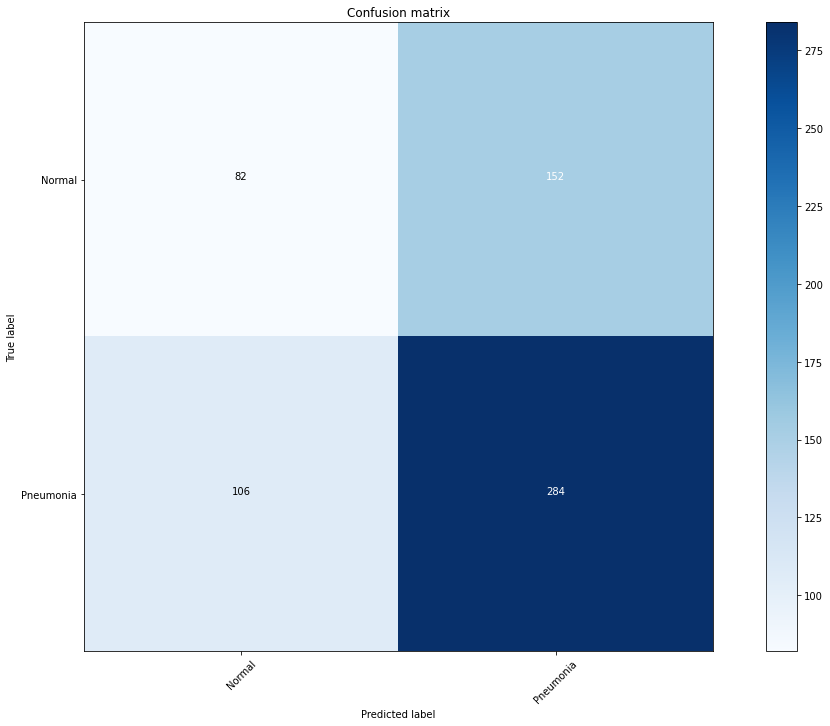

In [52]:
plt.figure(figsize=(15,10))
au.plot_confusion_matrix(cm3, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# Extracting Feature Map

In [13]:
img_path = 'chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'

/Users/michaelarmistead/FlatIronWork/Data Science Projects/FINAL/X-ray-Classification/Automate.py:149: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


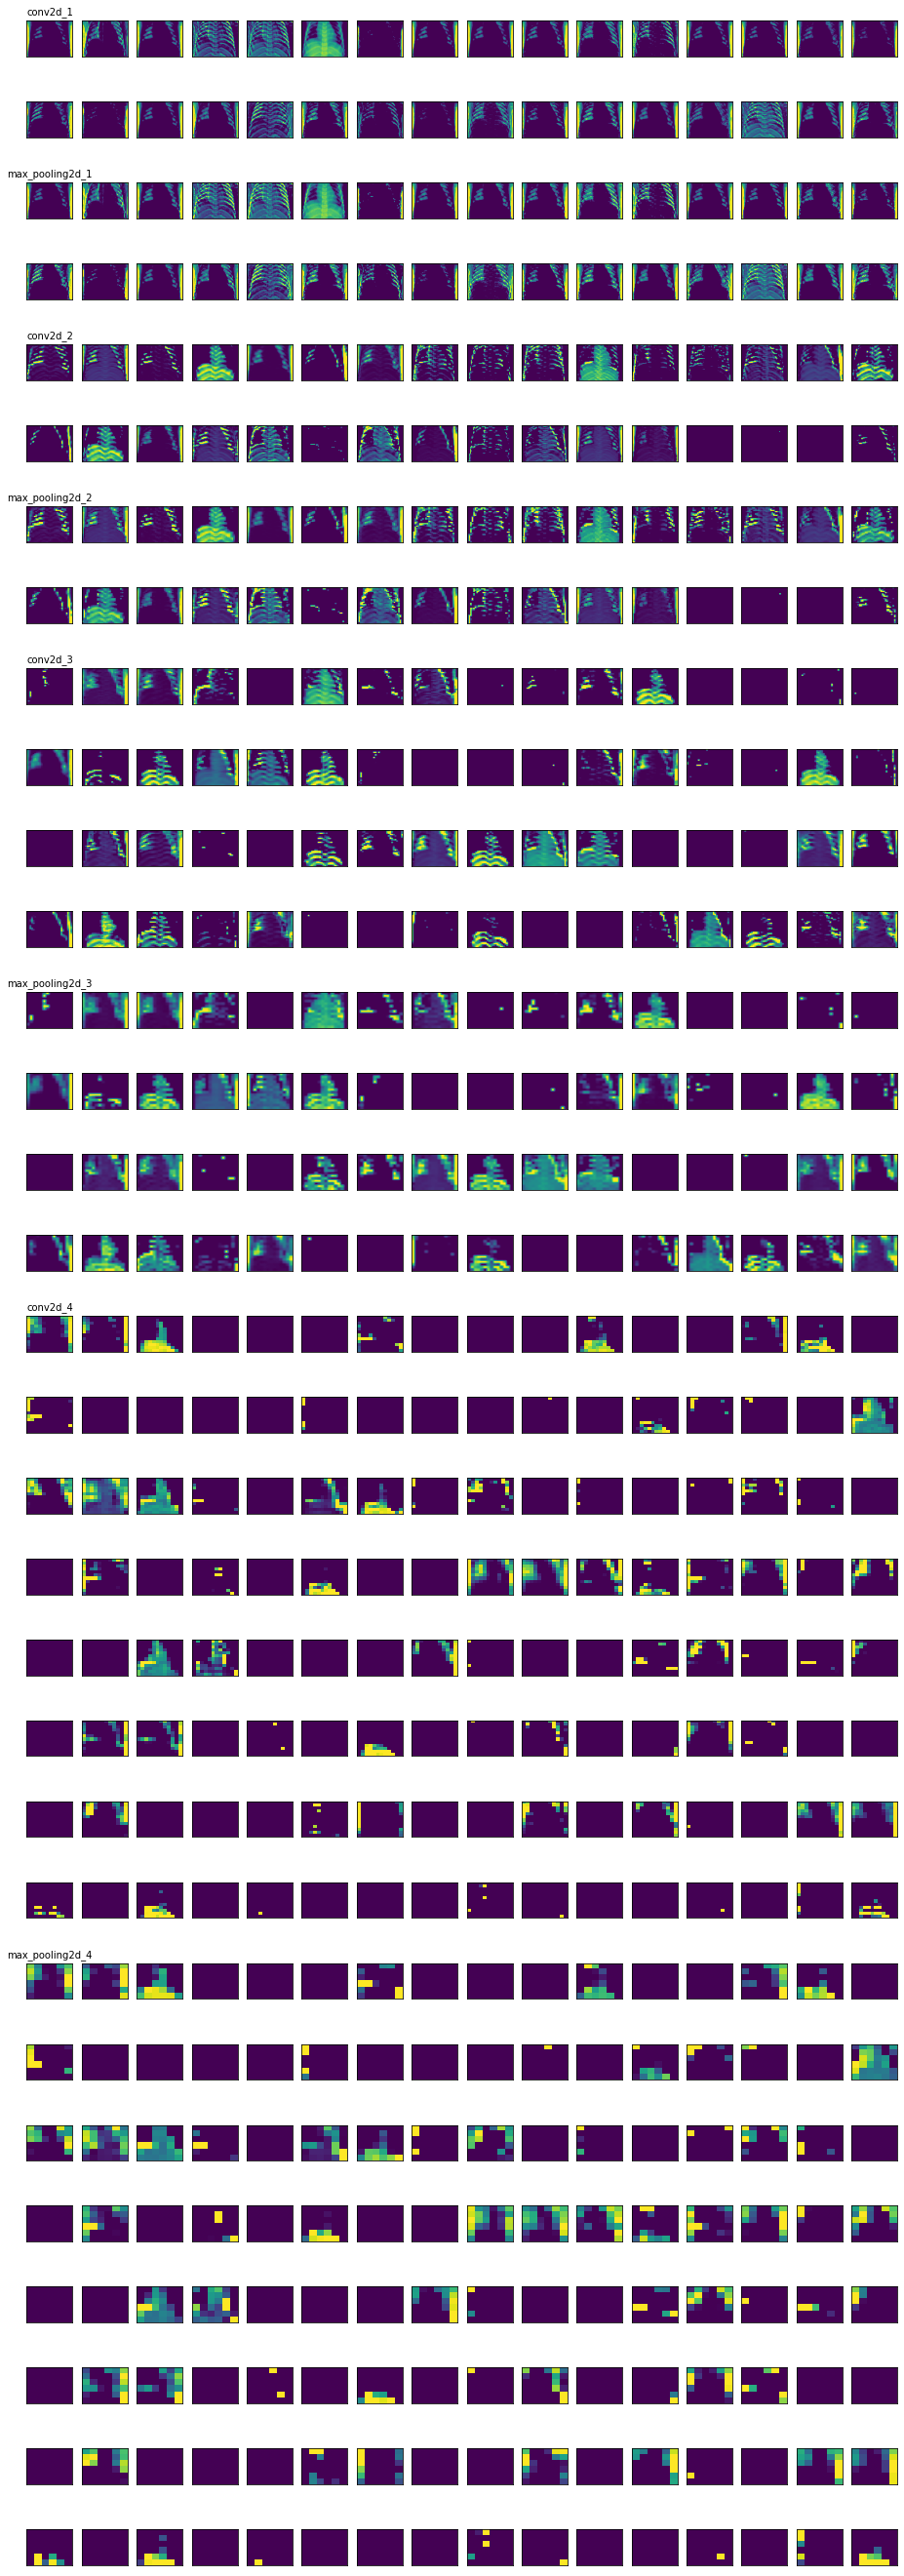

In [14]:
au.extracting_features_map(img_path, modelloadaug)

In [76]:
img_path = 'chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

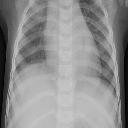

In [77]:
img

# Feature HeatMap

In [17]:
model = modelloadaug
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("max_pooling2d_4")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(128 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()
plt.imshow(superimposed_img)
plt.show()

IndexError: index 128 is out of bounds for axis 2 with size 128